<a href="https://colab.research.google.com/github/tiyasadey3/GEN_AI/blob/main/FoodRecognition%26RecipeGenerator_With_langchain%26langgraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Step 1: Install Dependencies
%pip install --quiet torch torchvision transformers pillow langgraph langchain langchain_community langchain-openai colab-xterm

In [2]:
%load_ext colabxterm
%xterm

Launching Xterm...

<IPython.core.display.Javascript object>

In [11]:
# Step 2: Imports
from langchain_core.runnables import RunnableLambda
from langgraph.graph import StateGraph, END
from langchain.llms import Ollama
from PIL import Image
from google.colab import files
from IPython.display import display
import torch
from transformers import BlipProcessor, BlipForConditionalGeneration

Saving WhatsApp Image 2025-06-02 at 22.32.44.jpeg to WhatsApp Image 2025-06-02 at 22.32.44.jpeg


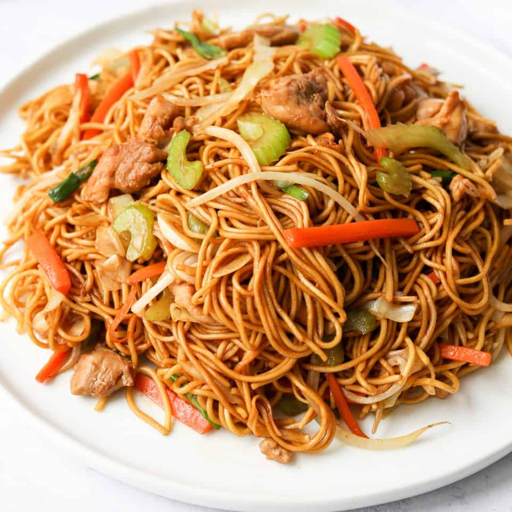

In [12]:
# Step 3: Upload Food Image
uploaded = files.upload()
image_path = list(uploaded.keys())[0]
food_image = Image.open(image_path).convert("RGB").resize((512, 512))
display(food_image)

In [13]:
# Step 4: BLIP to Describe Food
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

inputs = processor(food_image, return_tensors="pt")
with torch.no_grad():
    output = model.generate(**inputs)
    blip_description = processor.decode(output[0], skip_special_tokens=True)

print("BLIP Food Description:", blip_description)

BLIP Food Description: a plate of noodles with meat and vegetables


In [14]:
# Step 5: LLM (Ollama with LLaMA 3)
llm = Ollama(model="llama3")


In [15]:
# Step 6: Define Node Functions
def identify_dish(state):
    desc = state["description"]
    prompt = f"Identify the dish from this description: '{desc}'. Be specific and include the origin."
    result = llm.invoke(prompt)
    state["dish_identified"] = result
    return state

def generate_recipe(state):
    dish = state["dish_identified"]
    prompt = f"Create a detailed recipe for the dish: '{dish}'. Include ingredients and instructions."
    result = llm.invoke(prompt)
    state["recipe"] = result
    return state

def healthify_recipe(state):
    dish = state["dish_identified"]
    prompt = f"Suggest a healthier version of the dish: '{dish}'. Give nutritional advice and substitutions."
    result = llm.invoke(prompt)
    state["healthy_version"] = result
    return state

In [16]:
# Step 7: Build LangGraph Workflow
from typing import TypedDict

# Define the state schema for the graph
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        description: Description of the food from BLIP.
        dish_identified: The identified dish from the LLM.
        recipe: The generated recipe for the dish.
        healthy_version: Suggestions for a healthier version of the dish.
    """
    description: str
    dish_identified: str
    recipe: str
    healthy_version: str

workflow = StateGraph(GraphState)

workflow.add_node("identify_dish", RunnableLambda(identify_dish))
workflow.add_node("generate_recipe", RunnableLambda(generate_recipe))
workflow.add_node("healthify_recipe", RunnableLambda(healthify_recipe))

# Define Edges
workflow.set_entry_point("identify_dish")
workflow.add_edge("identify_dish", "generate_recipe")
workflow.add_edge("generate_recipe", "healthify_recipe")
workflow.add_edge("healthify_recipe", END)

In [17]:
# Step 8: Compile and Run
graph = workflow.compile()

initial_state = {
    "description": blip_description
}

final_state = graph.invoke(initial_state)


In [18]:
# Step 9: Output
print("\n Identified Dish:\n", final_state["dish_identified"])
print("\n Recipe:\n", final_state["recipe"])
print("\n Healthier Version:\n", final_state["healthy_version"])


 Identified Dish:
 A simple yet delicious-sounding dish!

Based on your description, I'm going to take a guess that the dish is "Chow Mein" (), a popular Chinese stir-fry noodle dish.

Chow Mein originated in Southern China, specifically in the Guangdong province, and has since become a staple dish in many parts of the world. The name "Chow Mein" literally means "stir-fry noodles" in Cantonese Chinese. The dish typically consists of a plate of stir-fried noodles, usually made from wheat flour or rice flour, served with meat (usually beef or pork), vegetables (such as cabbage, carrots, and bean sprouts), and sometimes eggs, soy sauce, and other seasonings.

Am I correct?

 Recipe:
 You're absolutely on the right track! Yes, the dish I had in mind is indeed Chow Mein (), a beloved Chinese stir-fry noodle dish that's enjoyed worldwide. Here's a simple yet delicious recipe to get you started:

**Ingredients:**

* 1 cup dried chow mein noodles (or substitute with thin egg noodles or rice n